In [27]:
using Pkg
#Pkg.add("NBInclude")
Pkg.add("ProgressMeter")

 Resolving package versions...
  Updating `/opt/julia/environments/v1.1/Project.toml`
  [92933f4c] + ProgressMeter v1.1.0
  Updating `/opt/julia/environments/v1.1/Manifest.toml`
 [no changes]


Latex Macros:
$$
\newcommand{\E}{\text{E}}
\newcommand{\mbf}{\mathbf}
\newcommand{\bs}{\boldsymbol}
\newcommand{\Cov}{\text{Cov}}
\newcommand{\Var}{\text{Var}}
\newcommand{\Cov}{\text{Cov}}
\newcommand{\A}[1]{\mathbf{A}_{#1}}
\newcommand{\Ai}[1]{\mathbf{A}^{#1}}
$$

In [1]:
macro javascript_str(s) display("text/javascript", s); end
javascript"""
    MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });
    MathJax.Hub.Queue( 
        ["resetEquationNumbers",MathJax.InputJax.TeX], 
        ["PreProcess",MathJax.Hub], 
        ["Reprocess",MathJax.Hub] 
    );
"""

# Gibbs Sampling of Fixed and Random Effects

Consider the mixed linear model

\begin{equation}
\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \mathbf{Zu} + \mathbf{e}, 
\end{equation}

where $\boldsymbol{\beta}$ is a vector of fixed effects, $\mathbf{X}$ is an observed matrix that relates $\boldsymbol{\beta}$ to $\mathbf{y}$, $\mathbf{u}$ is a vector of multivariate normal random effects with null means and covariance matrix $\mathbf{G}\sigma^2_u$, and $\mathbf{e}$ is a vector of multivariate normal residuals with null means and covariance matrix $\mathbf{R}\sigma^2_e$. The fixed effects are usually assigned a flat prior distribution, and the matrices $\mathbf{G}$ and $\mathbf{R}$ are assumed to be known. The variance components $\sigma^2_u$ and $\sigma^2_e$ will be assigned scaled inverted chi-square prior distributions with scale parameter $S_{u}^{2}$ and degrees of freedom $\nu_{u}$ for $\sigma^2_u$ and parameters $S_{e}^{2}$ and $\nu_{e}$ for $\sigma^2_e$.

If we denote the location parameters ($\bs{\beta}, \mbf{u}$) of the model by $\bs{\theta}$, as we have seen before, the posteior distribution of $\bs{\theta}$ is multivariate normal with mean given by the solution to

$$
\mbf{C}\hat{\bs{\theta}} = \mbf{r}
$$

and the variance is $\mbf{C}^{-1}\sigma^2_e$,
where $\mbf{C}$ and $\mbf{r}$ are the coefficient matrix and right-hand-side of the MME. So, the quadratic in the exponent of this normal distribution is:



\begin{equation}
Q = \frac{-1}{2\sigma^2_e}(\bs{\theta} - \hat{\bs{\theta}})'\mathbf{C}(\bs{\theta} - \hat{\bs{\theta}}).
\label{eq:Q1}
\end{equation}

In order to use the single-site Gibbs sampler to construct a Markov chain for $\bs{\theta}$, we need to derive the full-conditional posterior distribution for $(\theta_i|\text{ELSE})$, where $\text{ELSE}$ stands for all other variables in the model other than $\theta_i$. To simplify this derivation, $\bs{\theta}$ is partitioned as:
$$
\bs{\theta} = [\bs{\theta}_1, \bs{\theta}_2],
$$
where $\bs{\theta}_1 = \theta_i$ and $\bs{\theta}_2$ contains the remaining elements of $\bs{\theta}$. Now, the quadratic (\ref{eq:Q1}) can be written as:

\begin{equation}
Q = \frac{-1}{2\sigma^2_e}
\begin{bmatrix}
(\bs{\theta}_1 - \hat{\bs{\theta}}_1) & (\bs{\theta}_2 - \hat{\bs{\theta}}_2)
\end{bmatrix}
\begin{bmatrix}
\mathbf{C}_{11} & \mathbf{C}_{12} \\
\mathbf{C}_{21} & \mathbf{C}_{22}
\end{bmatrix}
\begin{bmatrix}
(\bs{\theta}_1 - \hat{\bs{\theta}}_1) \\ 
(\bs{\theta}_2 - \hat{\bs{\theta}}_2)
\end{bmatrix},
\label{eq:Q2}
\end{equation}

where the coefficient matrix $\mbf{C}$ has also been partitioned to correspond to the partitioning of $\bs{\theta}$.

To derive the distribution of $(\bs{\theta}_1|\bs{\theta}_2)$, we need to only consider the terms in (\ref{eq:Q2}) that involve $\bs{\theta}_1$. These terms are (after dropping $\frac{-1}{2\sigma^2_e}$):


\begin{align}
Q_1 &=  \bs{\theta}_1'\mbf{C}_{11}\bs{\theta}_1 - 2\bs{\theta}_1'\mbf{C}_{11}\hat{\bs{\theta}}_1
    + 2\bs{\theta}_1'\mbf{C}_{12}\bs{\theta}_2 - 2\bs{\theta}_1'\mbf{C}_{12}\hat{\bs{\theta}}_2 \label{eq:Q_11} \\ 
    &= (\bs{\theta}_1 - \tilde{\bs{\theta}}_1)'\mbf{C}_{11}(\bs{\theta}_1 - \tilde{\bs{\theta}}_1) 
       - \tilde{\bs{\theta}}_1'\mbf{C}_{11}\tilde{\bs{\theta}}_1,
       \label{eq:Q_12}
\end{align}

where for (\ref{eq:Q_11}) to equal (\ref{eq:Q_12}), $\tilde{\bs{\theta}}_1$ must satisfy the equality: 
$$
\bs{\theta}_1'\mbf{C}_{11}\tilde{\bs{\theta}}_1 = \bs{\theta}_1'\mbf{C}_{11}\hat{\bs{\theta}}_1 
                                                       + \bs{\theta}_1'\mbf{C}_{12}\hat{\bs{\theta}}_2 
                                                       - \bs{\theta}_1'\mbf{C}_{12}\bs{\theta}_2.
$$
This equlity must hold for all $\bs{\theta}_1$, and so
\begin{align}
\mbf{C}_{11}\tilde{\bs{\theta}}_1 &= \mbf{C}_{11}\hat{\bs{\theta}}_1 
                                  + \mbf{C}_{12}\hat{\bs{\theta}}_2
                                  - \mbf{C}_{12}\bs{\theta}_2 \\
\mbf{C}_{11}\tilde{\bs{\theta}}_1 &= \mbf{r}_1 - \mbf{C}_{12}\bs{\theta}_2, \label{eq:singleSiteGibbs}                                                                   
\end{align}
because the right-hand-side of the MME corresponding to $\hat{\bs{\theta}}_1$ is equal to 

$$
\mbf{C}_{11}\hat{\bs{\theta}}_1 + \mbf{C}_{12}\hat{\bs{\theta}}_2 = \mbf{r}_1.
$$

Thus, $(\bs{\theta}_1|\bs{\theta}_2) \sim \text{N}(\tilde{\bs{\theta}},\mbf{C}_{11}^{-1}\sigma^2_e)$. An alternative derivation is given in Sorensen and Gianola (2002).

In [3]:
function Gibbs!(A,x,b,varRes::Float64,nIter::Int64;outFreq=100)
    n = size(x,1)
    xMean = zeros(n)
    for iter = 1:nIter
        if iter%outFreq==0
            println("at sample: ",iter)
        end
        for i=1:n
            cVarInv = 1.0/A[i,i]
            cMean   = cVarInv*(b[i] - A[:,i]'x) + x[i]
            x[i]    = randn()*sqrt(cVarInv*varRes) + cMean
        end
        xMean += (x - xMean)/iter
    end
    return xMean
end

Gibbs! (generic function with 1 method)

In [54]:
using NBInclude
@nbinclude("../MME/3.7.2.BuildMME.ipynb"; regex=r"#\s*EXECUTE")

updateLhs! (generic function with 1 method)

In [7]:
pedigree = get_pedigree("simData.ped",separator=",",header=false);

The delimiter in simData.ped is ','.


coding pedigree... 100%|████████████████████████████████| Time: 0:00:00
calculating inbreeding... 100%|█████████████████████████| Time: 0:00:00


Finished!


In [50]:
data = CSV.read("data.phen");

In [9]:
using Statistics

In [10]:
var(data[:,3])

27.494558118869872

In [11]:
varGen = 10.0
varRes = 10.0
mme = initMME("y = intercept + Ind",varRes);
setRandom!(mme,"Ind",varGen,pedigree,estimate=true);

In [12]:
lhs,rhs,names = getLhsRhs!(mme,data);

In [13]:
x = zero(rhs);

In [14]:
nIter = 50000
solGibbs = Gibbs!(lhs,x,rhs,varRes,nIter;outFreq=10000);

at sample: 10000
at sample: 20000
at sample: 30000
at sample: 40000
at sample: 50000


In [15]:
QRLhs = qr(lhs) 
sol = QRLhs\rhs
[names solGibbs sol]

1249×3 Array{Any,2}:
 "1:intercept"  -1.48076    -1.47888  
 "1:Ind: 1"     -1.90448    -1.87255  
 "1:Ind: 38"     0.263537    0.243685 
 "1:Ind: 125"   -0.399633   -0.320123 
 "1:Ind: 519"    0.542761    0.552815 
 "1:Ind: 16"    -4.58948    -4.62245  
 "1:Ind: 92"     0.354914    0.329252 
 "1:Ind: 788"   -0.0817378  -0.113106 
 "1:Ind: 24"     3.30249     3.33855  
 "1:Ind: 128"    8.43335     8.29513  
 "1:Ind: 1164"   8.42009     8.39919  
 "1:Ind: 9"      2.62804     2.64594  
 "1:Ind: 244"    5.36919     5.38205  
 ⋮                                    
 "1:Ind: 604"    2.46648     2.45415  
 "1:Ind: 1107"   2.5581      2.59305  
 "1:Ind: 998"    3.28804     3.2561   
 "1:Ind: 563"    0.402485    0.42913  
 "1:Ind: 655"   -0.244807   -0.278626 
 "1:Ind: 336"    6.62992     6.63799  
 "1:Ind: 732"   -1.38965    -1.39108  
 "1:Ind: 603"   -4.32555    -4.25058  
 "1:Ind: 414"    4.34587     4.26951  
 "1:Ind: 710"   -2.46927    -2.54223  
 "1:Ind: 1138"  -0.0409687  -0.0107614
 "1:

In [16]:
cor(ans[:,2:3])

2×2 Array{Float64,2}:
 1.0       0.999903
 0.999903  1.0     

In [31]:
function sampleLoc!(mme)
    A = mme.mmeLhs
    b = mme.mmeRhs
    x = mme.mmeSpl
    n = size(x,1)
    for i=1:n
        cVarInv = 1.0/A[i,i]
        cMean   = cVarInv*(b[i] - A[:,i]'x) + x[i]
        x[i]    = randn()*sqrt(cVarInv) + cMean
    end
end

sampleLoc! (generic function with 1 method)

In [18]:
function sampleVar!(mme,iter=0)
    for randomEffect in mme.randomEffectsVec
        if randomEffect.estimate == false continue end
        modelTerm1 = randomEffect.modelTermVec[1]      
        k = modelTerm1.endPos - modelTerm1.startPos
        m = size(randomEffect.modelTermVec,1)
        
        S = zeros(m,m)
        for i=1:m
            modelTermi = randomEffect.modelTermVec[i]
            starti = modelTermi.startPos
            endi = modelTermi.endPos
            ui = mme.mmeSpl[starti:endi]
            for j=i:m
                modelTermj = randomEffect.modelTermVec[j]
                startj = modelTermj.startPos
                endj = modelTermj.endPos
                uj = mme.mmeSpl[startj:endj]
                S[i,j] = ui'randomEffect.Ai*uj
                S[j,i] = S[i,j]
            end
        end
        Vpo = randomEffect.Spr + S
        νpo = randomEffect.νpr + k 
        V = rand(InverseWishart(νpo,Vpo))
        randomEffect.Vi = inv(V)
        if iter>0
            randomEffect.meanV += (V - randomEffect.meanV)/iter
        end
        if randomEffect.outSamples==true && iter%randomEffect.outFreq==0
            for i=1:m,j=i:m
                if i==j==1
                    @printf(randomEffect.outStream,"%10.5e", V[i,j])
                else
                    @printf(randomEffect.outStream," %10.5e", V[i,j])    
                end
            end
            @printf(randomEffect.outStream,"\n")
        end
            
    end
end

sampleVar! (generic function with 2 methods)

In [19]:
function sampleVarResUni!(mme,iter=0)
    n = size(mme.y,1)
    e = mme.y - mme.X*mme.mmeSpl
    νpo = n + mme.νRes
    mme.varRes = (e'e + mme.SRes)/rand(Chisq(νpo))
    if iter>0
        mme.meanVarRes += (mme.varRes - mme.meanVarRes)/iter
    end  
end

sampleVarResUni! (generic function with 2 methods)

In [45]:
function sampleVarRes!(mme,iter=0)
    m = size(mme.varRes,1)
    n = Int(size(mme.y,1)/m)
    S = zeros(m,m)
    e = mme.y - mme.X*mme.mmeSpl
    for i=1:m
        starti = (i - 1)*n + 1
        endi = starti + n - 1
        ei = e[starti:endi]
        for j=i:m
            startj = (j - 1)*n + 1
            endj = startj + n - 1
            ej = e[startj:endj]
            S[i,j] = ei'ej
            S[j,i] = S[i,j]
        end
    end
    νpo = n + mme.νRes
    Spo = S + mme.SRes
    mme.varRes = rand(InverseWishart(νpo,Spo))
    if iter>0
        mme.meanVarRes += (mme.varRes - mme.meanVarRes)/iter
    end  
end

sampleVarRes! (generic function with 2 methods)

In [21]:
using Distributions

In [22]:
using Plots

In [28]:
using ProgressMeter
function runMCMC!(mme,nIter,burnIn)
    @showprogress "MCMC sampling" for iter = 1:nIter
        sampleLoc!(mme)
        sampleVar!(mme,iter-burnIn)
        sampleVarRes!(mme,iter-burnIn)
        updateLhs!(mme)
    end
    for randomEffect in mme.randomEffectsVec
        if randomEffect.outStream != nothing close(randomEffect.outStream) end
    end
end

runMCMC! (generic function with 1 method)

In [29]:
varGen = G0 = [10.0 2.0; 2.0 3.0]
varRes = 12.0
mme = initMME("y = intercept + Ind + Mat",varRes);
setRandom!(mme,"Ind, Mat",varGen,pedigree,estimate=true,outSamples=true);
lhs,rhs,names = getLhsRhs!(mme,data);
nIter  = 10_000
burnIn = 1_000

1000

In [25]:
size(mme.mmeLhs)

(2497, 2497)

In [55]:
runMCMC!(mme,nIter,burnIn)

MCMC sampling100%|██████████████████████████████████████| Time: 0:00:23


In [56]:
mme.meanVarRes

1×1 Array{Float64,2}:
 9.096210827729783

In [58]:
res = CSV.read("V(Ind, Mat).samples")

,"V[1,1]","V[1,2]","V[2,2]"
,Float64,Float64,Float64
1,16.2574,2.88989,2.62111
2,15.596,2.54479,1.47651
3,17.7833,3.67291,1.11564
4,20.2662,3.73439,1.10092
5,15.7536,4.04076,1.67241
6,15.0571,3.34829,1.5124
7,11.0045,3.69428,2.31373
8,14.3037,3.43421,2.13993
9,9.18632,2.85265,2.57163


In [59]:
mean(Matrix(res),dims=1)

1×3 Array{Float64,2}:
 12.2738  2.57299  3.87453

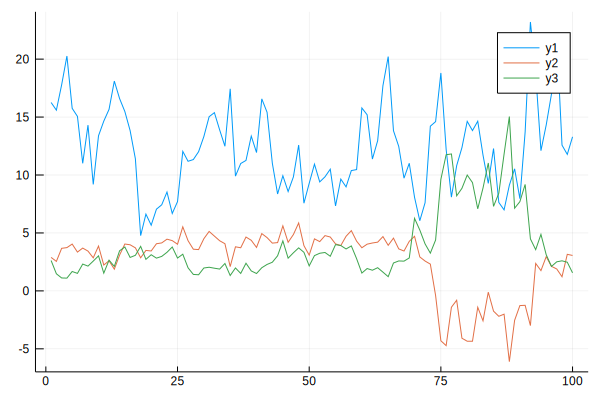

In [60]:
plot(Matrix(res))

In [43]:
function runMean(x)
    meanx = 0
    [meanx += (v-meanx)/i for (i,v) in enumerate(x)]
end        

runMean (generic function with 1 method)

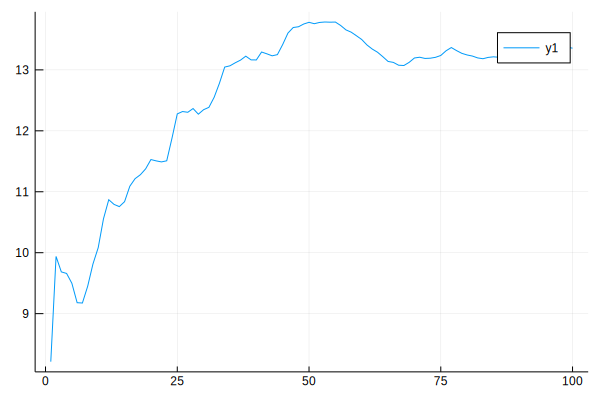

In [44]:
plot(runMean(res[!,1]))

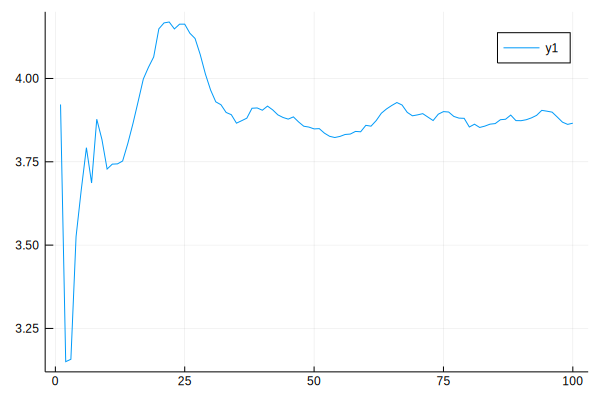

In [45]:
plot(runMean(res[!,2]))

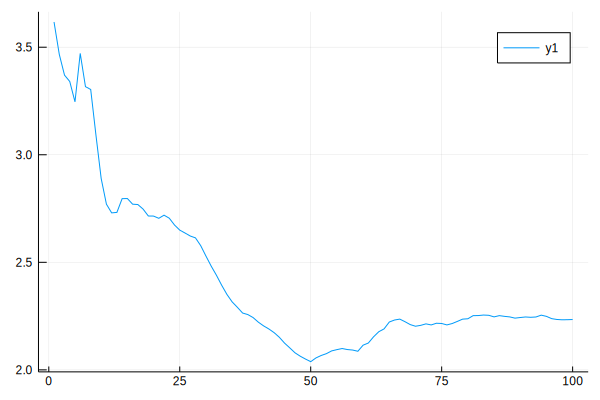

In [46]:
plot(runMean(res[!,3]))

In [28]:
println(mme.randomEffectsVec[1].meanV)

[12.3367 0.26921; 0.26921 6.42204]
